## Analysis part 2

In [1]:
from config import CONFIG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import series_to_supervised
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_json("eth-donation-requests.json")

In [3]:
df['tagged_begging'] = pd.to_datetime(df['tagged_begging'])

In [4]:
df = df.set_index(pd.DatetimeIndex(df['tagged_begging']))

In [5]:
df = df.groupby(pd.Grouper(key='tagged_begging', freq='15Min', base=0, label='right'))

In [6]:
df = df.describe()

In [7]:
df_count = df.unstack()['tagged_begging']['count']

In [8]:
values = df_count.values
#df_count.head()
type(values)

numpy.ndarray

In [9]:
values.shape

(9788,)

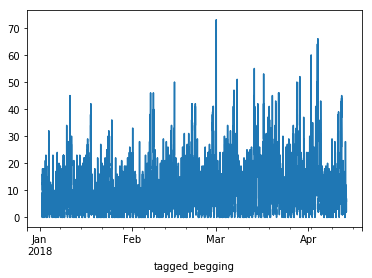

In [10]:
ax = df_count.plot()
plt.show()

In [11]:
# parameters to prepare the dataset for learning # param 
n_lag = 96
n_out = 4
n_features = 1
n_lag,n_features,n_out

(96, 1, 4)

In [12]:
values.shape

(9788,)

In [13]:
values = values.reshape(values.shape[0], 1)
#values = values.reshape(-1, 1)

In [14]:
values.shape

(9788, 1)

In [15]:
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# frame as supervised learning
#reframed = series_to_supervised(scaled, n_lag, n_out)
reframed = series_to_supervised(scaled, n_lag, n_out)
reframed.head()

,var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),var1(t-90),var1(t-89),var1(t-88),var1(t-87),...,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
96,0.027397,0.082192,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,...,0.041096,0.054795,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082
97,0.082192,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,...,0.054795,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192
98,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,...,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986
99,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,0.219178,...,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986,0.150685
100,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,0.219178,0.178082,...,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986,0.150685,0.191781


In [17]:
reframed_values = reframed.values
# split into train and test sets
training_size = int(0.8* reframed_values.shape[0])
train = reframed_values[:training_size, :]
test = reframed_values[training_size:, :]

In [18]:
# split into input and outputs
n_obs = n_lag * n_features

# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

n_outputs = n_out * n_features
train_x, train_y = train[:, :n_obs], train[:, -n_out:]
test_x, test_y = test[:, :n_obs], test[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_lag, n_features))
test_x = test_x.reshape((test_x.shape[0], n_lag, n_features))

# reshape output to be 3D [samples, timesteps, features]
train_y = train_y.reshape(-1, n_out, 1)
test_y = test_y.reshape(-1, n_out, 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((7751, 96, 1), (7751, 4, 1), (1938, 96, 1), (1938, 4, 1))


In [19]:
model_name="model.json"
model_weights_name="weights.h5"

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM, CuDNNLSTM, GRU,CuDNNGRU
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint

units= CONFIG['lstm_hidden_size']
dropout = .1

# design network
model = Sequential()
model.add(Bidirectional(LSTM(units), input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(dropout))

model.add(RepeatVector(n_out))

model.add(LSTM(units/2, return_sequences=True))
model.add(Dropout(dropout))

# We're only concerned with the estimating the close value,
# otherwise use n_outputs instead of 1
# Dense(n_outputs, ...
model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(loss='mse', optimizer='adam')

# store model
# serialize model to JSON
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)

model.summary()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 25)             12600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 25)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 1)              26        
Total params: 33,426
Trainable params: 33,426
Non-trainable params: 0
_________________________________________________________________


In [33]:
#epochs=100
epochs=100
batch_size=512

In [34]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose=1, shuffle=False,
                    callbacks=[ModelCheckpoint(model_weights_name, monitor='val_loss', verbose=1,save_best_only='true',
                                              save_weights_only=True)])

Train on 7751 samples, validate on 1938 samples
Epoch 1/100
7751/7751 [==============================] - 13s 2ms/step - loss: 0.0040 - val_loss: 0.0059

Epoch 00001: val_loss improved from inf to 0.00590, saving model to weights.h5
Epoch 2/100
7751/7751 [==============================] - 16s 2ms/step - loss: 0.0041 - val_loss: 0.0059

Epoch 00002: val_loss did not improve from 0.00590
Epoch 3/100
7751/7751 [==============================] - 11s 1ms/step - loss: 0.0041 - val_loss: 0.0057

Epoch 00003: val_loss improved from 0.00590 to 0.00568, saving model to weights.h5
Epoch 4/100
7751/7751 [==============================] - 12s 2ms/step - loss: 0.0041 - val_loss: 0.0058

Epoch 00004: val_loss did not improve from 0.00568
Epoch 5/100
7751/7751 [==============================] - 12s 1ms/step - loss: 0.0040 - val_loss: 0.0056

Epoch 00005: val_loss improved from 0.00568 to 0.00559, saving model to weights.h5
Epoch 6/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.

7751/7751 [==============================] - 10s 1ms/step - loss: 0.0037 - val_loss: 0.0057

Epoch 00052: val_loss did not improve from 0.00557
Epoch 53/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0037 - val_loss: 0.0058

Epoch 00053: val_loss did not improve from 0.00557
Epoch 54/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0036 - val_loss: 0.0059

Epoch 00054: val_loss did not improve from 0.00557
Epoch 55/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0036 - val_loss: 0.0059

Epoch 00055: val_loss did not improve from 0.00557
Epoch 56/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0036 - val_loss: 0.0057

Epoch 00056: val_loss did not improve from 0.00557
Epoch 57/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0036 - val_loss: 0.0057

Epoch 00057: val_loss did not improve from 0.00557
Epoch 58/100
7751/7751 [==============================] - 10s 1ms/step 

In [35]:
# Load the best weights
model.load_weights(model_weights_name)
model.compile(loss='mse', optimizer='adam')
score = model.evaluate(test_x, test_y, verbose=1)

1938/1938 [==============================] - 3s 1ms/step


In [36]:
score

0.00554605241626082

In [37]:
from matplotlib import pyplot

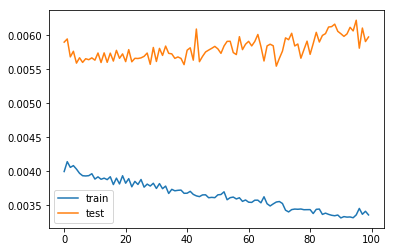

In [38]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# Test the prediction of test data
y = model.predict(test_x)

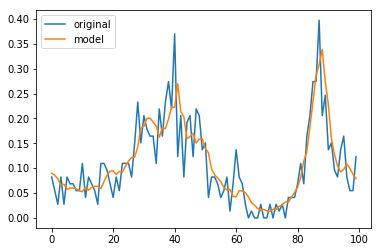

In [40]:
a = test_y[:,0]
b = y[:,0]
c = np.append(b, y[-1], axis=0)

# Show how the model fits the test data
pyplot.plot(a[:100], label='original')
pyplot.plot(b[:100], label='model')
pyplot.legend()
pyplot.show()

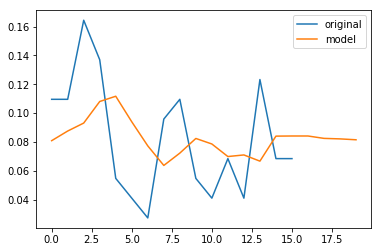

In [41]:
# Show how the model predicts data
pos = int(a.shape[0]-n_out*4)
pyplot.plot(a[pos:], label='original')
pyplot.plot(c[pos:], label='model')
pyplot.legend()
pyplot.show()